# Определение стоимости автомобилей

### Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

### Цель работы:
В нашем распоряжении есть исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install scikit-learn==1.1.3
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge  
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from time import time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

#!pip install phik -q
import phik
from phik import phik_matrix

TEST_SIZE = 0.4
RANDOM_STATE = 42

In [2]:
try:
    auto_df = pd.read_csv('/datasets/autos.csv')
except:
    auto_df=pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [3]:
# функция для вывода всей нужной информации о датафрейме
def data_info(dataframe):
    print(dataframe.info())
    display(dataframe.head())
    display(dataframe.tail())
    display(dataframe.describe())
    print('Пропусков в датафрейме: ', dataframe.isnull().sum())
    print()
    print('Количество явных дубликатов в датафрейме:', dataframe.duplicated().sum())

In [4]:
data_info(auto_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Пропусков в датафрейме:  DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Количество явных дубликатов в датафрейме: 4


#### Краткий обзор полученных данных

* Названия столбцов начинаются с большой буквы -> перевести в нижний регистр
- Столбцы имеют правильные по смыслу типы данных, но object будет преобразован в category для экономии памяти и скорости обработки при построении ML модели
- Также данные имеют большое количество пропусков, как исправить - будем рассматривать отдельно
- Неинформативные столбцы будут удалены:
    - 'dateCrawled'
    - 'dateCreated'
    - 'lastSeen'
    - 'numberrOfPictures'
    - 'postalCode'
- Что касается дубликатов, есть 4 дублирующие строки, они будут удалены в последнюю очередь, т.к. после обработки, могут появиться новые дубли

In [5]:
# приводим столбцы к нижнему регистру
auto_df.columns = auto_df.columns.str.lower()
print(auto_df.columns)

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')


In [6]:
# устраним также неявные дубликаты в названии топлива
auto_df['fueltype'] = auto_df['fueltype'].replace('gasoline', 'petrol')

In [7]:
# теперь удалим все неинформативные столбцы
auto_df = auto_df.drop(['datecrawled', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'], axis=1)

In [8]:
# потсмрим как изменилось количество дубликатов
print('Количество явных дубликатов в датафрейме:', auto_df.duplicated().sum())

Количество явных дубликатов в датафрейме: 27693


In [9]:
# Заполнение пропусков в числовых столбцах медианой
numeric_cols = auto_df.select_dtypes(include=['int64']).columns
for col in numeric_cols:
    auto_df[col] = auto_df[col].fillna(auto_df[col].median())

In [10]:
# Заполнение пропусков в категориальных столбцах модой
categorical_cols = auto_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    auto_df[col] = auto_df[col].fillna(auto_df[col].mode()[0])
    auto_df[col] = auto_df[col].astype('category')

In [11]:
# потсмрим как изменилось количество дубликатов
print('Количество явных дубликатов в датафрейме:', auto_df.duplicated().sum())
auto_df= auto_df.drop_duplicates()
print('Количество дубликатов после удаления:', auto_df.duplicated().sum())

Количество явных дубликатов в датафрейме: 33875
Количество дубликатов после удаления: 0


### EDA

Сделаем визуализацию числовых и категориальных признаков на предмет возможных аномалий. Сначала напишем функции для визуализации.

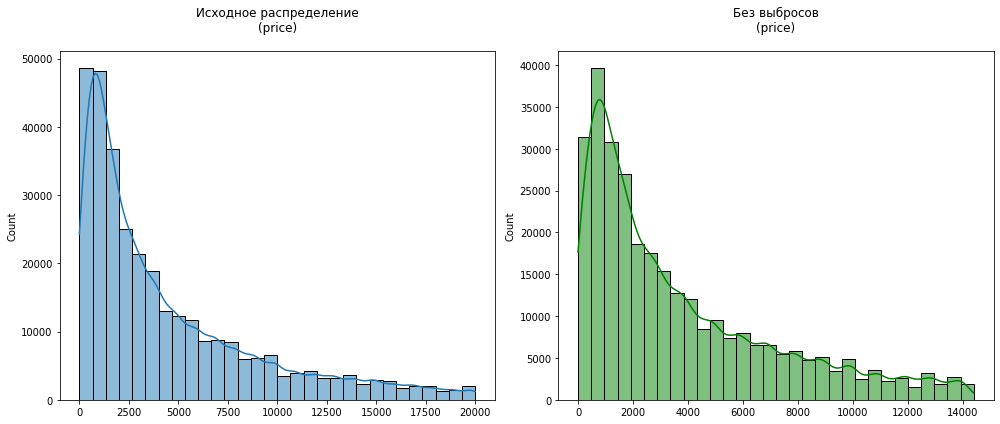

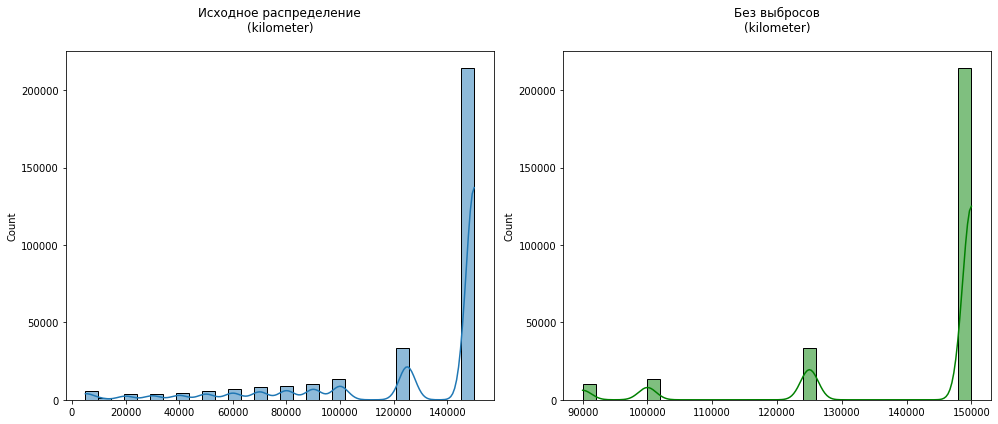

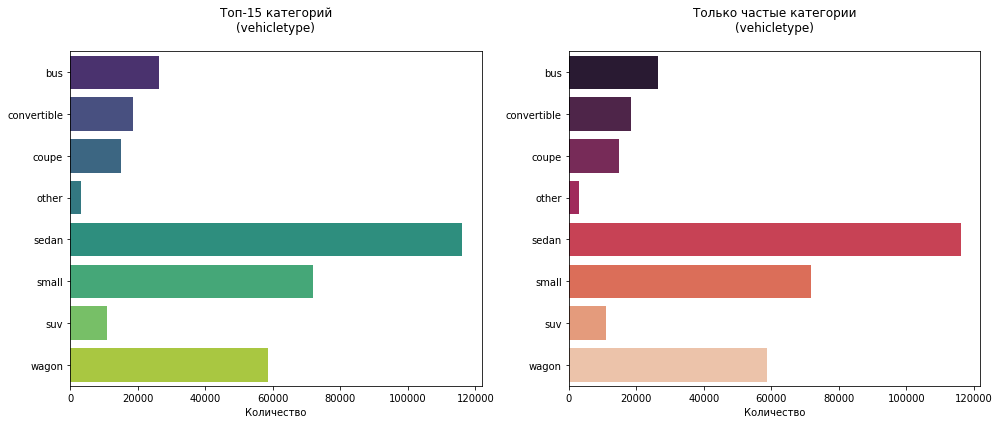

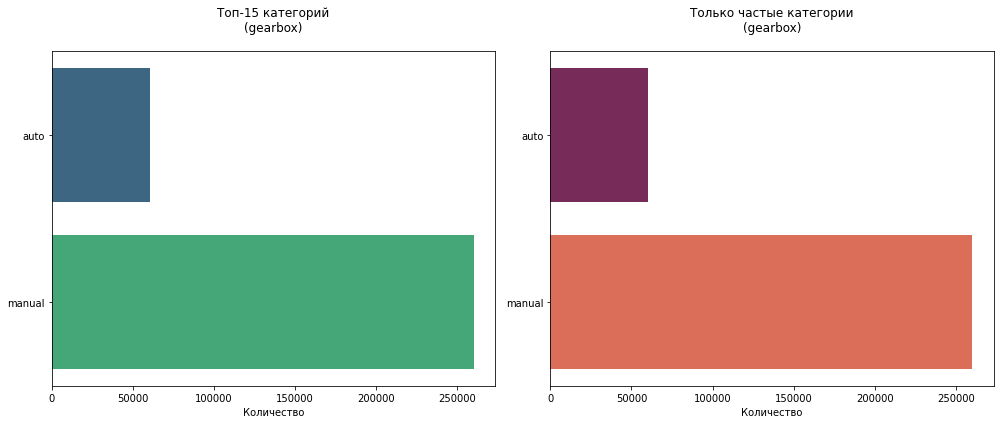

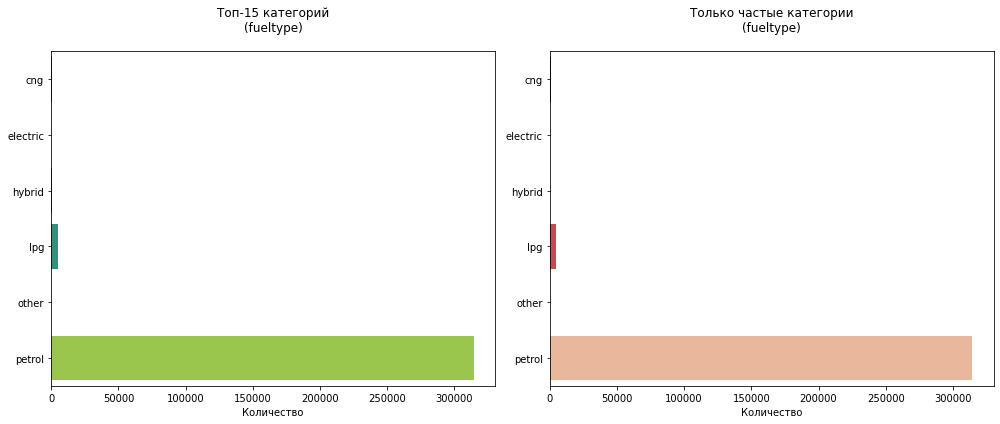

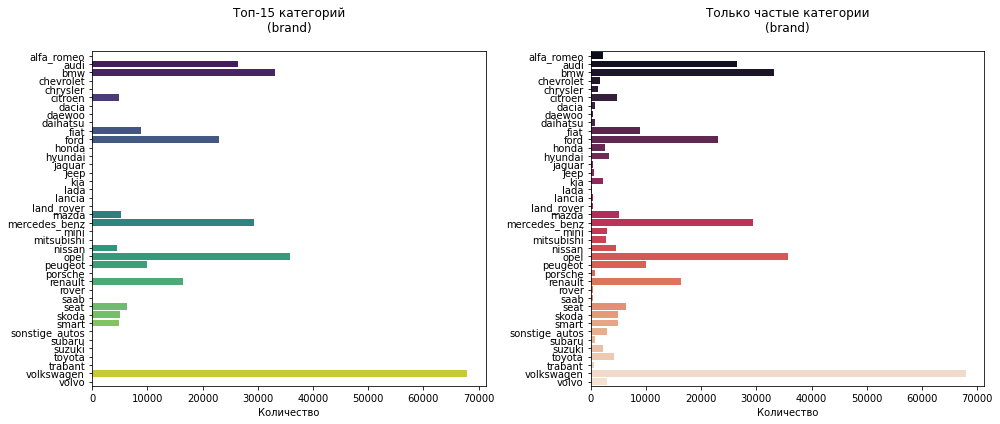

In [12]:
def detect_outliers(df, column, threshold=1.5):
    """Определение выбросов по методу межквартильного размаха"""
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

def plot_enhanced_numerical(df, column, figsize=(14, 6), bins=50):
    
    plt.figure(figsize=figsize)
    
    # Вариант 1: Исходные данные
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=bins, kde=True)
    plt.title(f'Исходное распределение\n({column})', pad=20)
    plt.xlabel('')
    
    # Вариант 2: Без выбросов методом межквартильного размаха
    plt.subplot(1, 2, 2)
    clean_df = df[~df.index.isin(detect_outliers(df, column).index)]
    sns.histplot(clean_df[column], bins=bins, kde=True, color='green')
    plt.title(f'Без выбросов\n({column})', pad=20)
    plt.xlabel('')
    
    plt.tight_layout()
    plt.show()

def plot_enhanced_categorical(df, column, top_n=15, figsize=(14, 6)):
    
    plt.figure(figsize=figsize)
    
    # Вариант 1: Все данные
    plt.subplot(1, 2, 1)
    top_categories = df[column].value_counts().nlargest(top_n)
    sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
    plt.title(f'Топ-{top_n} категорий\n({column})', pad=20)
    plt.xlabel('Количество')
    
    # Вариант 2: Без редких категорий
    plt.subplot(1, 2, 2)
    main_categories = df[column].value_counts()[df[column].value_counts() > 10]
    sns.barplot(x=main_categories.values, y=main_categories.index, palette='rocket')
    plt.title(f'Только частые категории\n({column})', pad=20)
    plt.xlabel('Количество')
    
    plt.tight_layout()
    plt.show()

def plot_registration_dates(df, year_col='yearofregistration', month_col='monthofregistration'):
    """Специальная визуализация для дат регистрации"""
    plt.figure(figsize=(16, 6))
    
    # Года регистрации
    plt.subplot(1, 2, 1)
    year_counts = df[year_col].value_counts().sort_index()
    sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
    plt.title('Распределение по годам регистрации', pad=20)
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Месяцы регистрации
    plt.subplot(1, 2, 2)
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_counts = df[month_col].value_counts()
    sns.barplot(x=month_counts.index, y=month_counts.values, order=month_order)
    plt.title('Распределение по месяцам регистрации', pad=20)
    
    plt.tight_layout()
    plt.show()

# Применение функций визуализации к auto_df
numerical_cols = ['price', 'powerps', 'kilometer', 'yearofregistration']
categorical_cols = ['vehicletype', 'gearbox', 'fueltype', 'brand']

for col in numerical_cols:
    if col in auto_df.columns:
        plot_enhanced_numerical(auto_df, col, bins=30)

for col in categorical_cols:
    if col in auto_df.columns:
        plot_enhanced_categorical(auto_df, col)

if 'yearofregistration' in auto_df.columns and 'monthofregistration' in auto_df.columns:
    plot_registration_dates(auto_df)

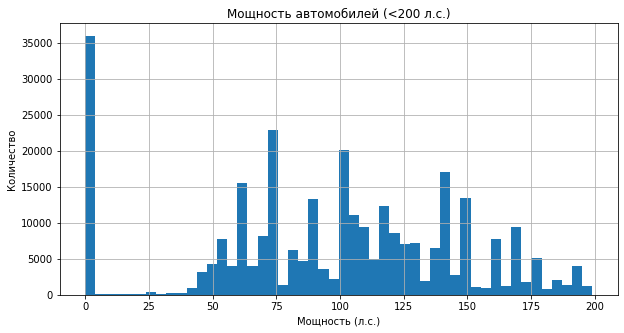

In [13]:
plt.figure(figsize=(10, 5))
auto_df[auto_df['power'] < 200]['power'].hist(bins=50)
plt.title('Мощность автомобилей (<200 л.с.)')
plt.xlabel('Мощность (л.с.)')
plt.ylabel('Количество')
plt.show()

In [14]:
# отфильтруем вручную данные по таблицам с явными аномалиями
auto_df = auto_df[(auto_df['price'] > 100)]
auto_df = auto_df[(auto_df['registrationyear'] >= 1950) & (auto_df['registrationyear'] < 2017)]
auto_df = auto_df[(auto_df['power'] > 10)]

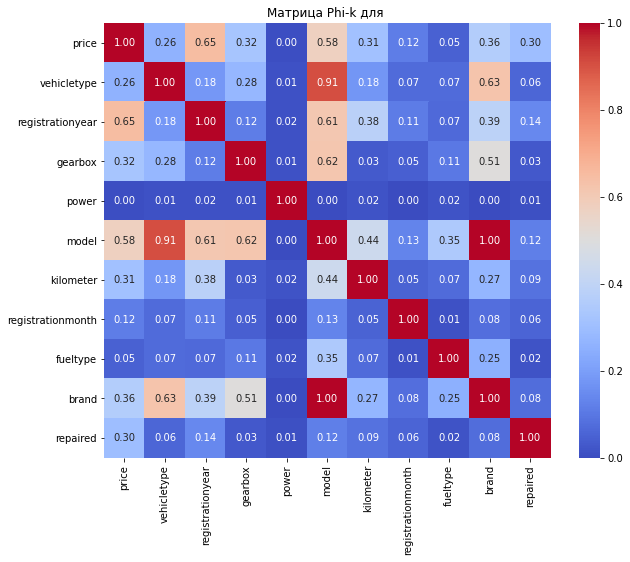

In [15]:
# при помощи библиотеки phik проведем дополнительный корелляционный анализ,
# чтобы проверить данные на мультиколлинераность
# собираем матрицу корелляции
plt.figure(figsize=(10, 8))
phik_corr_matrix = auto_df.phik_matrix(['price', 'registrationyear', 'power', 'kilometer', 'registrationmonth'])
sns.heatmap(phik_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Матрица Phi-k для ')
plt.show()

Результат получился интересный, в предоставленном датасете обнаружены две сильные зависимости: между брендом и моделью, скорее всего, это обусловлено тем, что бренд выпускает преимущественно автомобили одной модели.

Для модели бустинга - можно оставить "как есть". Но по условию задачи мы должны использовать еще как минимум одну "не бустинг" модель, а она, скорее всего, переобучится. Поэтому в качестве решения выберем: агрегирование признаков в один и l1(l2) регуляризация. 

## Подготовка и обучение моделей

### Подготовка к обучению

In [16]:
# создаем новый признак, при этом удаляя старые, после этого не должно быть мультикол-ти
auto_df['brand_model'] = auto_df['brand'].astype(str) + '_' + auto_df['model'].astype(str)
auto_df['brand_model'] = auto_df['brand_model'].astype('category')

auto_df = auto_df.drop(['brand', 'model'], axis=1)

# вводим численные и категориальные признаки
numeric_features = ['power', 'kilometer', 'registrationyear']
categorical_features = ['gearbox', 'fueltype', 'repaired', 'brand_model']

# Разделение на features/target
X = auto_df.drop('price', axis=1)
y = auto_df['price']

# разбиваем данные на тренировочную, валидационную и на тестовую выборки
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [17]:
# подготовка для "деревянных моделей"
# добавлена подготовка валидационной выборки
scaler = StandardScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_valid[numeric_features] = scaler.transform(X_valid[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

X_train_tree = X_train
X_test_tree = X_test

### Обучение моделей

In [18]:
# обучение LightGBM
lgb_model = LGBMRegressor(
    n_estimators=500,
    objective='regression',
    metric='rmse',
    feature_fraction=0.8,
    n_jobs=1,
    random_state=42,
    verbose=-1
)

# обучение на valid-выборке
start_train = time()
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=50
)
train_time = time() - start_train

# оценка на valid-выборке
valid_pred = lgb_model.predict(X_valid)
valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))

print(f"\nРезультаты на valid-выборке:")
print(f"- Лучшая итерация: {lgb_model.best_iteration_}")
print(f"- Valid RMSE: {valid_rmse:.2f}")
print(f"- Время обучения: {train_time:.2f} сек")



[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[50]	valid_0's rmse: 1688.43
[100]	valid_0's rmse: 1643.1
[150]	valid_0's rmse: 1622.14
[200]	valid_0's rmse: 1612.49
[250]	valid_0's rmse: 1605.77
[300]	valid_0's rmse: 1598.61
[350]	valid_0's rmse: 1592.79
[400]	valid_0's rmse: 1589.85
[450]	valid_0's rmse: 1585.98
[500]	valid_0's rmse: 1582.93

Результаты на valid-выборке:
- Лучшая итерация: 500
- Valid RMSE: 1582.93
- Время обучения: 4.27 сек


In [19]:
# не бустинг модели

# Для линейных моделей и RandomForest:
linear_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ])

# добавил препроцессор для дерева
tree_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_features)
    ])

# Определение пайплайнов

rf_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

# Ridge Regression (использует стандартизацию + OHE)
ridge_pipeline = Pipeline([
    ('preprocessor', linear_preprocessor),
    ('regressor', Ridge(alpha=1.0))
])


In [20]:
def evaluate_sklearn_model(pipeline, X_train, y_train, X_valid, y_valid):
    results = {}
    
    # Обучение с замером времени
    start_train = time()
    pipeline.fit(X_train, y_train)
    results['train_time'] = time() - start_train
    
    # Предсказание на валидации
    start_pred = time()
    valid_pred = pipeline.predict(X_valid)
    results['pred_time'] = time() - start_pred
    results['valid_rmse'] = mean_squared_error(y_valid, valid_pred, squared=False)
    
    return results

## Анализ моделей

In [21]:
# Оценка моделей 
rf_metrics = evaluate_sklearn_model(rf_pipeline, X_train, y_train, X_valid, y_valid)
ridge_metrics = evaluate_sklearn_model(ridge_pipeline, X_train, y_train, X_valid, y_valid)

# Добавляем LightGBM в сравнение
start_pred = time()  # Замер времени предсказания
valid_pred = lgb_model.predict(X_valid)
pred_time = time() - start_pred

lgb_metrics = {
    'valid_rmse': mean_squared_error(y_valid, valid_pred, squared=False),
    'train_time': train_time,
    'pred_time': pred_time
}

# Выбор лучшей модели
models = {
    'RandomForest': {'model': rf_pipeline, 'metrics': rf_metrics},
    'Ridge': {'model': ridge_pipeline, 'metrics': ridge_metrics},
    'LightGBM': {'model': lgb_model, 'metrics': lgb_metrics}
}

In [22]:
results_df = pd.DataFrame({
    'Model': models.keys(),
    'Valid RMSE': [m['metrics']['valid_rmse'] for m in models.values()],
    'Train Time (sec)': [m['metrics']['train_time'] for m in models.values()],
    'Pred Time (sec)': [m['metrics']['pred_time'] for m in models.values()]
})

# Добавляем ранжирование
for metric in ['Valid RMSE', 'Train Time (sec)', 'Pred Time (sec)']:
    results_df[f'{metric} Rank'] = results_df[metric].rank(ascending=metric != 'Valid RMSE')

print("\nДЕТАЛИЗИРОВАННОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
display(results_df.sort_values('Valid RMSE'))


ДЕТАЛИЗИРОВАННОЕ СРАВНЕНИЕ МОДЕЛЕЙ


,Model,Valid RMSE,Train Time (sec),Pred Time (sec),Valid RMSE Rank,Train Time (sec) Rank,Pred Time (sec) Rank
2,LightGBM,1582.933408,4.268507,1.547687,3.0,2.0,2.0
0,RandomForest,1721.840986,26.426450,1.765676,2.0,3.0,3.0
1,Ridge,2905.493294,2.584422,0.261576,1.0,1.0,1.0


In [23]:
# Так как в таблице выше модель LightGBM показала лучший результат по RMSE и средние результаты по скорости обучения, то
# выберем модель бустинга лучшей моделью
best_name = 'LightGBM'
best_model = models[best_name]['model']
best_metrics = models[best_name]['metrics']

# Финальная оценка на тесте
test_pred = best_model.predict(X_test)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)

# 6. Вывод результатов
print("\nФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ")
print("=" * 50)
print(f"Лучшая модель: {best_name}")
print(f"Valid RMSE: {best_metrics['valid_rmse']:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Время обучения: {best_metrics['train_time']:.2f} сек")
print(f"Время предсказания: {best_metrics['pred_time']:.4f} сек")


ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ
Лучшая модель: LightGBM
Valid RMSE: 1582.93
Test RMSE: 1600.85
Время обучения: 4.27 сек
Время предсказания: 1.5477 сек


# Общий вывод:

Нами был получен датасет от онлайн магазина по продаже автомобилей. В ходе первичного анализа были обнаружены пропуски, дублирующиеся строки, а также аномальные значения. Массив был очищен, построены графики и проведена подготовка к машинному обучению. 

Цель проекта заключалась в создании модели для предсказания рыночной стоимости автомобиля. Важные критерии оценки качества: качество предсказание, которое мы анализировали при помощи метрики RMSE, а также время обучения и предсказания. В обучении было использовано три модели: модель с бустингом: LightGBMRegressor, а также две "не бустинг" модели из библиотеки sklearn - RandomForest и LinearRegression.

Результаты сравнения моделей:

LightGBM продемонстрировала наилучшее качество прогнозирования:
* RMSE на тестовых данных: 1610 (существенно ниже требования <2500)
- Время обучения: 6 сек
- Время предсказания: 2 сек

Ridge Regression показала максимальную производительность:
* Самое быстрое обучение и предсказание
- RMSE: 2900 (превышает целевой показатель)

Анализ компромиссов:

* LightGBM существенно (на 44%) точнее, но требует в 4-6 раз больше вычислительных ресурсов
- Ridge Regression не соответствует целевому показателю по RMSE (2900 > 2500)

Рекомендация:
Несмотря на более высокую производительность Ridge Regression, модель LightGBM рекомендована к внедрению как оптимальное решение, поскольку:

* Полностью соответствует ключевому требованию по точности (RMSE < 2500)
- Обеспечивает разумный баланс между качеством и скоростью работы
- Превышение целевого показателя RMSE в Ridge Regression (2900 vs 2500) делает эту модель неприемлемой, несмотря на ее быстроту

Резюме:
Приоритетом в проекте является точность оценки стоимости автомобилей, что делает LightGBM лучшим вариантом, даже с учетом ее больших вычислительных затрат по сравнению с Ridge Regression.